In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
from collections import defaultdict
import argparse
import gzip
from scipy import stats
import scipy as sp
import operator
import community
import datetime
import json

from network_ei import *
from get_motifs import *
from causal_emergence import *

import matplotlib.patches as mpatches
from matplotlib import gridspec
from matplotlib._png import read_png
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

%matplotlib inline

In [2]:
colors = ["#ff802b", "#ff802b", "#008ded", "#d7dc00", "#008ded", "#d2349e"]
colors = ["#fd7334", "#008fd7", "#b070f3", "#ffd62a", "#00a78c", "#ce428a"]
# colors = ["#ac9c3d", "#6778d0", "#56ae6c", "#9750a1", "#ba543d", "#b94a73"]


pharangeal_neurons = ["I1L","I1R","I2L","I2R","I3","I4","I5","I6",
                      "M1","M2L","M2R","M3L","M3R","M4","M5",
                      "MCL","MCR","MI","NSML","NSMR"]

nonmating_neurons  = ['ALNL','ALNR','AN1a','AN1b','AN2a','AN2b','AVKL','AVKR','DVA' ,'PDEL','PDER',
                      'PHCL','PHCR','PLML','PLMR','PLNL','PLNR','PVDL','PVDR','PVM','PQR',
                      'PVQL','PVQR','PVR','PVWL','PVWR']

other_dumb_neurons = ['intestine', 'anal', 'hyp']

tmus = ['MDL01', 'MDL02', 'MDL03', 'MDL04', 'MDL05', 'MDL06', 
        'MDL07', 'MDL08', 'MDL09', 'MDL10', 'MDL11', 'MDL12',
        'MDL13', 'MDL14', 'MDL15', 'MDL16', 'MDL17', 'MDL18', 
        'MDL19', 'MDL20', 'MDL21', 'MDL22', 'MDL23', 'MDL24', 
        'MDR01', 'MDR02', 'MDR03', 'MDR04', 'MDR05', 'MDR06', 
        'MDR07', 'MDR08', 'MDR09', 'MDR10', 'MDR11', 'MDR12', 
        'MDR13', 'MDR14', 'MDR15', 'MDR16', 'MDR17', 'MDR18', 
        'MDR19', 'MDR20', 'MDR21', 'MDR22', 'MDR23', 'MDR24', 
        'MVL01', 'MVL02', 'MVL03', 'MVL04', 'MVL05', 'MVL06', 
        'MVL07', 'MVL08', 'MVL09', 'MVL10', 'MVL11', 'MVL12', 
        'MVL13', 'MVL14', 'MVL15', 'MVL16', 'MVL17', 'MVL18', 
        'MVL19', 'MVL20', 'MVL21', 'MVL22', 'MVL23', 
        'MVR01', 'MVR02', 'MVR03', 'MVR04', 'MVR05', 'MVR06', 
        'MVR07', 'MVR08', 'MVR09', 'MVR10', 'MVR11', 'MVR12', 
        'MVR13', 'MVR14', 'MVR15', 'MVR16', 'MVR17', 'MVR18', 
        'MVR19', 'MVR20', 'MVR21', 'MVR22', 'MVR23', 'MVR24']

emus = ['dBWML1', 'dBWML2', 'dBWML3', 'dBWML4', 'dBWML5', 'dBWML6', 
        'dBWML7', 'dBWML8', 'dBWML9', 'dBWML10','dBWML11','dBWML12',
        'dBWML13','dBWML14','dBWML15','dBWML16','dBWML17','dBWML18',
        'dBWML19','dBWML20','dBWML21','dBWML22','dBWML23','dBWML24', 
        'dBWMR1', 'dBWMR2', 'dBWMR3', 'dBWMR4', 'dBWMR5', 'dBWMR6', 
        'dBWMR7', 'dBWMR8', 'dBWMR9', 'dBWMR10','dBWMR11','dBWMR12',
        'dBWMR13','dBWMR14','dBWMR15','dBWMR16','dBWMR17','dBWMR18',
        'dBWMR19','dBWMR20','dBWMR21','dBWMR22','dBWMR23','dBWMR24', 
        'vBWML1', 'vBWML2', 'vBWML3', 'vBWML4', 'vBWML5', 'vBWML6', 
        'vBWML7', 'vBWML8', 'vBWML9', 'vBWML10','vBWML11','vBWML12',
        'vBWML13','vBWML14','vBWML15','vBWML16','vBWML18','vBWML17',
        'vBWML19','vBWML20','vBWML21','vBWML22','vBWML23',
        'vBWMR1', 'vBWMR2', 'vBWMR3', 'vBWMR4', 'vBWMR5', 'vBWMR6', 
        'vBWMR7', 'vBWMR8', 'vBWMR9', 'vBWMR10','vBWMR11','vBWMR12',
        'vBWMR13','vBWMR14','vBWMR15','vBWMR16','vBWMR17','vBWMR18',
        'vBWMR19','vBWMR20','vBWMR21','vBWMR22','vBWMR23','vBWMR24']

muscles = dict(zip(emus, tmus))


total_dumb_neurons = list(set(other_dumb_neurons + pharangeal_neurons))
# total_dumb_neurons = list(set(other_dumb_neurons + pharangeal_neurons + hmmmmmm))

# Towlson Data

In [3]:
fn = "data/celeg-varshney-natpaperlayout.cyjs"
with open(fn, "r") as read_file:
    data = json.load(read_file)

varshney_node_data = data['elements']['nodes']
varshney_edge_data = data['elements']['edges']

# Varshney node data 
varshney_node_pos  = [(varshney_node_data[i]['position']['x'], 
                    -1*varshney_node_data[i]['position']['y'])   for i in range(len(varshney_node_data))]
varshney_node_label = [varshney_node_data[i]['data']['name']     for i in range(len(varshney_node_data))]
varshney_node_list  = [varshney_node_data[i]['data']['id']       for i in range(len(varshney_node_data))]
varshney_node_funct = [varshney_node_data[i]['data']['Function'] for i in range(len(varshney_node_data))]
varshney_node_id  = list(range(len(varshney_node_list)))
varshney_node_mapping = dict(zip(varshney_node_list, varshney_node_label))

color_mapping = dict(zip(np.unique(varshney_node_funct), colors))
varshney_node_color = [color_mapping[col] for col in varshney_node_funct]
varshney_colordict = dict(zip(varshney_node_label, varshney_node_color))

# Varshney edge data
varshney_edge_list = [(varshney_edge_data[i]['data']['source'], 
                       varshney_edge_data[i]['data']['target']) for i in range(len(varshney_edge_data))]

varshney_edge_list_betterlabels = [(varshney_node_mapping[eij[0]],varshney_node_mapping[eij[1]]) \
                                   for eij in varshney_edge_list]

# Varshney Data
https://www.researchgate.net/profile/Alicia_Costalago_Meruelo/publication/283572979/figure/fig1/AS:381222866964480@1467902022272/Body-wall-muscles-of-the-C-elegans-divided-into-four-quadrants-from-head-to-tail.jpg

In [4]:
# varshney_node_data
# class structure, Left vs Right
# remove muscles

In [5]:
weird_nodes = ['avfl','avfr','NMJ','VC06']
G_varshney = nx.DiGraph()
varshney_weights = {}
varshney_edgetype = {}
with open("data/Varshney_herm_full_edgelist.txt", 'r') as f:
    for line in f:
        nodei, nodej, edgetype, weigh = line.strip().split(',')
        varshney_weights[(nodei, nodej)] = weigh
        varshney_edgetype[(nodei, nodej)] = edgetype
        G_varshney.add_edge(nodei, nodej, weight=float(weigh))

# nx.set_edge_attributes(G_varshney, varshney_edgetype, 'edgetype')
G_varshney.remove_nodes_from(weird_nodes)

In [6]:
for nodei, nodej in varshney_edge_list_betterlabels:
    if nodei or nodej not in G_varshney.nodes():
        G_varshney.add_edge(nodei, nodej, weight=1.0)

In [7]:
varshney_label_pos   = dict(zip(varshney_node_label, varshney_node_pos))
varshney_label_funct = dict(zip(varshney_node_label, varshney_node_funct))
varshney_dict_pos = {}
varshney_dict_funct = {}
varshney_dict_color = {}
for node in G_varshney.nodes():
    if node in list(varshney_label_pos.keys()):
        varshney_dict_pos[node]  = varshney_label_pos[node]
        varshney_dict_funct[node] = varshney_label_funct[node]
        varshney_dict_color[node] = varshney_colordict[node]
        
nx.set_node_attributes(G_varshney, varshney_dict_pos,   'pos')
nx.set_node_attributes(G_varshney, varshney_dict_color, 'color')
nx.set_node_attributes(G_varshney, dict(zip(list(G_varshney.nodes()),list(G_varshney.nodes()))), 'name')
G_varshney = nx.convert_node_labels_to_integers(G_varshney, first_label=0, ordering='default')

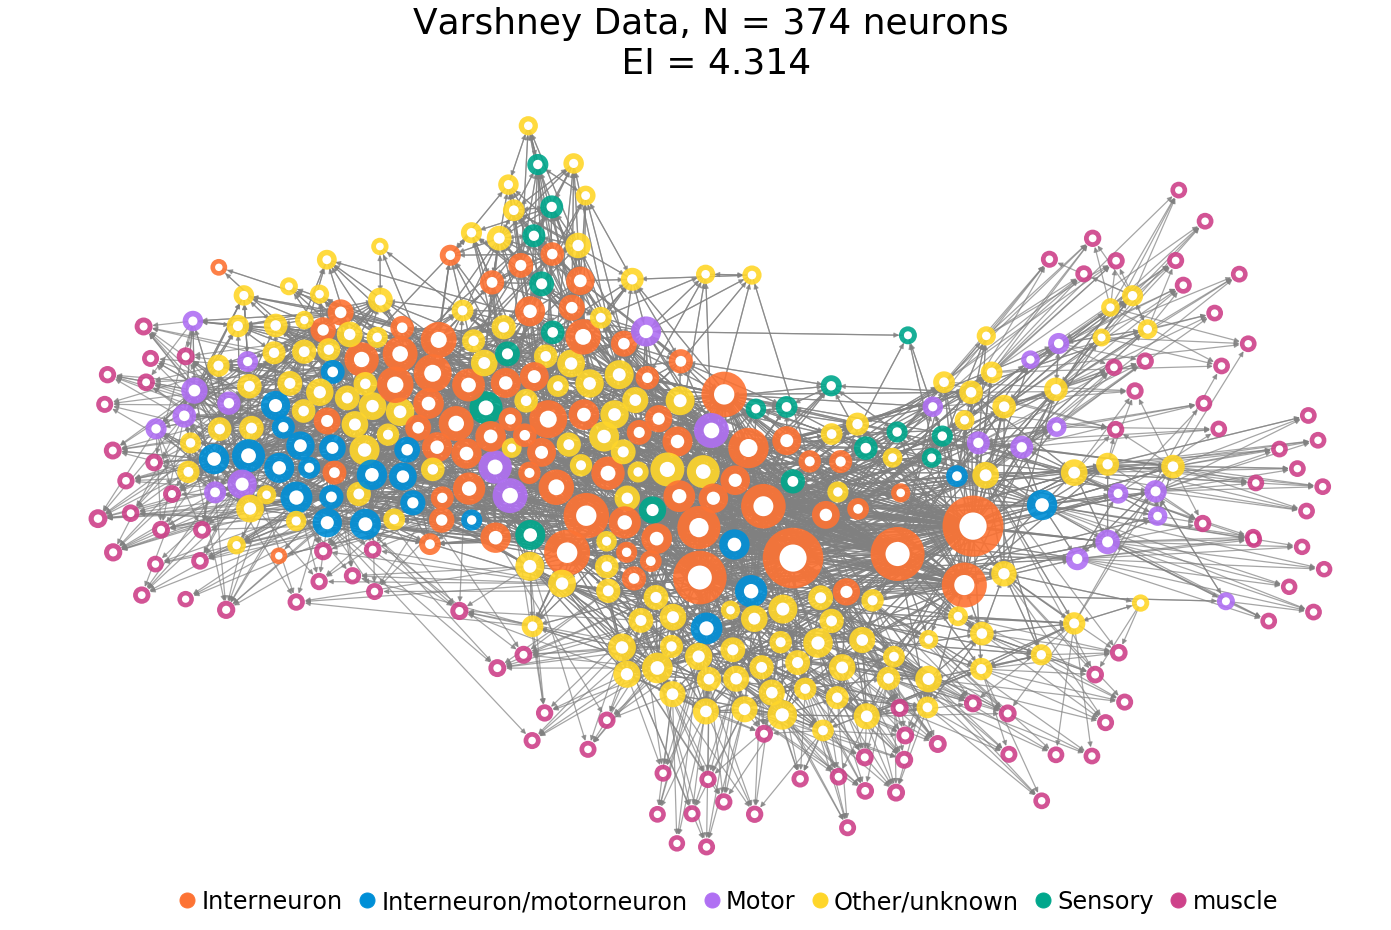

In [8]:
h = 10
w = 16
mult = 1.5
paddin = 100
varshney_node_size = np.array(list(dict(G_varshney.degree()).values()))/G_varshney.number_of_edges()
nx.set_node_attributes(G_varshney, dict(zip(list(G_varshney.nodes()), varshney_node_size)), 'size')

ns_v  = (np.array(list(nx.get_node_attributes(G_varshney, 'size').values()))*15000)**1.23*mult + 250
nc_v  =  np.array(list(nx.get_node_attributes(G_varshney,'color').values()))
pos_v =  np.array(list(nx.get_node_attributes(G_varshney,  'pos').values()))

plt.figure(figsize=(w*mult,h*mult))
nx.draw_networkx_nodes(G_varshney, pos=pos_v, node_color=nc_v, node_size=ns_v,   linewidths=0, alpha=0.9)
nx.draw_networkx_nodes(G_varshney, pos=pos_v, node_color='w',  node_size=ns_v/5, linewidths=0, alpha=1.0)
nx.draw_networkx_edges(G_varshney, pos=pos_v, edge_color="grey", width=1.25, alpha=0.7)
# nx.draw_networkx_labels(G_varshney, pos=pos_v, labels=nx.get_node_attributes(G_varshney, 'name'), font_size=10)
plt.axis('off')

for i in color_mapping.keys():
    plt.plot([-10000], [10000], color=color_mapping[i], marker='o', markersize=15, linestyle='', label=i)

plt.legend(fontsize=16*mult, columnspacing=0.0, handletextpad=-0.4, loc=3, framealpha=0.0, ncol=6, 
           bbox_to_anchor=(0.05*mult, -0.05))

plt.title("Varshney Data, N = %i neurons\n EI = %.3f"%(G_varshney.number_of_nodes(), get_ei(G_varshney)), size=36)
x, y = zip(*pos_v)
plt.xlim(min(x)-100, max(x)+100)
plt.ylim(min(y)-100, max(y)+100)
# plt.savefig("../figs/pngs/Varshney_celegans.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Varshney_celegans.pdf", bbox_inches='tight')
plt.show()

# Emmons Data

In [9]:
G_emmons = nx.DiGraph()
emmons_weights = {}
emmons_edgetype = {}
with open("data/Emmons_herm_full_edgelist.txt", 'r') as f:
    for line in f:
        nodei, nodej, weigh, edgetype = line.strip().split(',')
        if nodei in list(muscles.keys()):
            nodei = muscles[nodei]
        if nodej in list(muscles.keys()):
            nodej = muscles[nodej]            
        emmons_weights[(nodei, nodej)] = weigh
        emmons_edgetype[(nodei, nodej)] = edgetype
        G_emmons.add_edge(nodei, nodej, weight=float(weigh))

nx.set_edge_attributes(G_emmons, emmons_edgetype, 'edgetype')
G_emmons.remove_nodes_from(total_dumb_neurons)

nx.set_node_attributes(G_emmons, dict(zip(list(G_emmons.nodes()),list(G_emmons.nodes()))), 'name')

In [10]:
labels_varsh = nx.get_node_attributes(G_varshney, 'name')
counter = max(labels_varsh.keys())
nodes_emmon = list(G_emmons.nodes())
labels_emmon = {}

for node in nodes_emmon:
    for nums, lab in labels_varsh.items():
        if node == lab: 
            labels_emmon[node] = nums
            
for node in nodes_emmon:
    if node not in labels_emmon.keys():
        counter += 1
        labels_emmon[node] = counter 
        
G_emmons = nx.relabel_nodes(G_emmons, labels_emmon)

In [11]:
emmons_node_pos = {}
emmons_node_col = {}
fixed_pos = []
for i in sorted(G_emmons.nodes()):
    if i in list(G_varshney.nodes()):
        emmons_node_pos[i] = nx.get_node_attributes(G_varshney, 'pos')[i]
        emmons_node_col[i] = nx.get_node_attributes(G_varshney, 'color')[i]
        fixed_pos.append(i)
    else: 
        emmons_node_pos[i] = (np.random.uniform(-300,700),np.random.uniform(200,570))
        emmons_node_col[i] = 'limegreen'
        
nx.set_node_attributes(G_emmons, emmons_node_pos, 'pos')
nx.set_node_attributes(G_emmons, emmons_node_col, 'color')

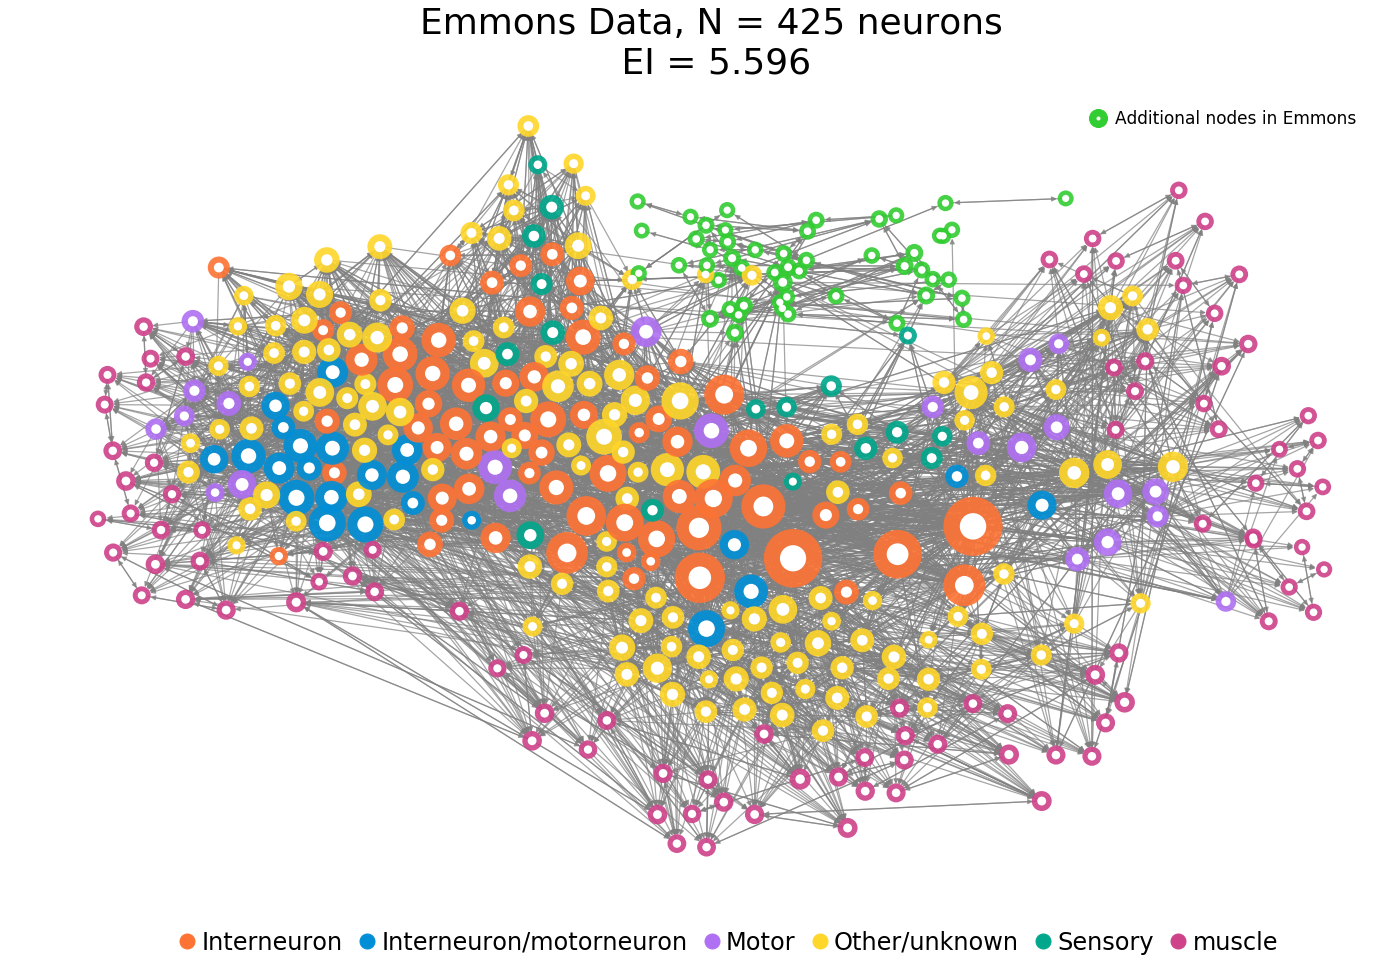

In [ ]:
h = 10
w = 16
mult = 1.5
paddin = 100
emmons_node_size = np.array(list(dict(G_emmons.degree()).values()))/G_emmons.number_of_edges()
nx.set_node_attributes(G_emmons, dict(zip(list(G_emmons.nodes()), emmons_node_size)), 'size')

ns_e  = (np.array(list(nx.get_node_attributes(G_emmons, 'size').values()))*7000)**1.5*mult + 250
nc_e  =  np.array(list(nx.get_node_attributes(G_emmons,'color').values()))
pos_e = nx.spring_layout(G_emmons, pos=nx.get_node_attributes(G_emmons, 'pos'), fixed=fixed_pos, iterations=1)

plt.figure(figsize=(w*mult,h*mult))
nx.draw_networkx_nodes(G_emmons, pos=pos_e, node_color=nc_e, node_size=ns_e,   linewidths=0, alpha=0.9)
nx.draw_networkx_nodes(G_emmons, pos=pos_e, node_color='w',  node_size=ns_e/5, linewidths=0, alpha=1.0)
nx.draw_networkx_edges(G_emmons, pos=pos_e, edge_color="grey", width=1.25, alpha=0.7)

plt.axis('off')

for i in color_mapping.keys():
    plt.plot([-10000], [10000], color=color_mapping[i], marker='o', markersize=15, linestyle='', label=i)

plt.text(700, 700, "Additional nodes in Emmons", fontsize=17)
plt.plot([670], [710], marker='o', linestyle='', color='limegreen', markersize=18)
plt.plot([670], [710], marker='o', linestyle='', color='w', markersize=3)
plt.legend(fontsize=16*mult, columnspacing=0.0, handletextpad=-0.4, loc=3, framealpha=0.0, ncol=6, 
           bbox_to_anchor=(0.05*mult, -0.1))

plt.title("Emmons Data, N = %i neurons\n EI = %.3f"%(G_emmons.number_of_nodes(), get_ei(G_emmons)), size=36)
x, y = zip(*list(pos_e.values()))
plt.xlim(min(x)-100, max(x)+100)
plt.ylim(min(y)-100, max(y)+100)
# plt.savefig("../figs/pngs/Emmons_celegans.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Emmons_celegans.pdf", bbox_inches='tight')
plt.show()

# Comparing Both Networks

In [ ]:
w = 16*2
h = 11
mult = 1.5
paddin = 100

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(w*mult,h*mult))

# Varshney
nx.draw_networkx_nodes(G_varshney, pos=pos_v, node_color=nc_v, node_size=ns_v,   linewidths=0, alpha=0.9, ax=ax0)
nx.draw_networkx_nodes(G_varshney, pos=pos_v, node_color='w',  node_size=ns_v/5, linewidths=0, alpha=1.0, ax=ax0)
nx.draw_networkx_edges(G_varshney, pos=pos_v, edge_color="grey", width=1.25, alpha=0.7, ax=ax0)
ax0.set_title("Varshney Data, N = %i neurons\n EI = %.3f"%(G_varshney.number_of_nodes(), get_ei(G_varshney)), size=36)
x, y = zip(*pos_v)
ax0.set_xlim(min(x)-100, max(x)+100)
ax0.set_ylim(min(y)-100, max(y)+100)
ax0.set_axis_off()

# Emmons
nx.draw_networkx_nodes(G_emmons, pos=pos_e, node_color=nc_e, node_size=ns_e,   linewidths=0, alpha=0.9, ax=ax1)
nx.draw_networkx_nodes(G_emmons, pos=pos_e, node_color='w',  node_size=ns_e/5, linewidths=0, alpha=1.0, ax=ax1)
nx.draw_networkx_edges(G_emmons, pos=pos_e, edge_color="grey", width=1.25, alpha=0.7, ax=ax1)
ax1.set_title("Emmons Data, N = %i neurons\n EI = %.3f"%(G_emmons.number_of_nodes(), get_ei(G_emmons)), size=36)
x, y = zip(*list(pos_e.values()))
ax1.set_xlim(min(x)-100, max(x)+100)
ax1.set_ylim(min(y)-100, max(y)+100)
ax1.set_axis_off()

for i in color_mapping.keys():
    ax0.plot([-10000], [10000], color=color_mapping[i], marker='o', markersize=15, linestyle='', label=i)

ax1.text(700, 700, "Additional nodes in Emmons", fontsize=20)
ax1.plot([650], [710], marker='o', linestyle='', color='limegreen', markersize=18)
ax1.plot([650], [710], marker='o', linestyle='', color='w', markersize=3)
ax0.legend(fontsize=20*mult, columnspacing=0.0, handletextpad=-0.4, loc=3, framealpha=0.0, ncol=6, 
           bbox_to_anchor=(0.26*mult, -0.1))

# plt.savefig("../figs/pngs/Emmons_Varshney_compare.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Emmons_Varshney_compare.pdf", bbox_inches='tight')
plt.show()

In [25]:
# nx.get_node_attributes(G_emmons, 'name')
# nx.get_node_attributes(G_varshney, 'name')
# From 373 on is end organs stuff and remove most
# everything beginning with a lower case is not a neuron 

In [14]:
Gv2 = G_varshney.copy()
Ge2 = G_emmons.copy()

In [15]:
e_nodes = list(range(279, 425))
v_nodes = list(range(279, 374))

In [16]:
Gv2.remove_nodes_from(v_nodes)
Ge2.remove_nodes_from(e_nodes)

In [17]:
print(Gv2.number_of_nodes())
print(Ge2.number_of_nodes())

279
279


In [18]:
emmons_node_size = np.array(list(dict(Ge2.degree()).values()))/Ge2.number_of_edges()
nx.set_node_attributes(Ge2, dict(zip(list(Ge2.nodes()), emmons_node_size)), 'size')

ns_e  = (np.array(list(nx.get_node_attributes(Ge2, 'size').values()))*7000)**1.5*mult + 250
nc_e  =  np.array(list(nx.get_node_attributes(Ge2,'color').values()))
# pos_e = nx.spring_layout(Ge2, pos=nx.get_node_attributes(Ge2, 'pos'), fixed=fixed_pos, iterations=1)

varshney_node_size = np.array(list(dict(Gv2.degree()).values()))/Gv2.number_of_edges()
nx.set_node_attributes(Gv2, dict(zip(list(Gv2.nodes()), varshney_node_size)), 'size')

ns_v  = (np.array(list(nx.get_node_attributes(Gv2, 'size').values()))*15000)**1.23*mult + 250
nc_v  =  np.array(list(nx.get_node_attributes(Gv2,'color').values()))
# pos_v =  np.array(list(nx.get_node_attributes(Gv2,  'pos').values()))

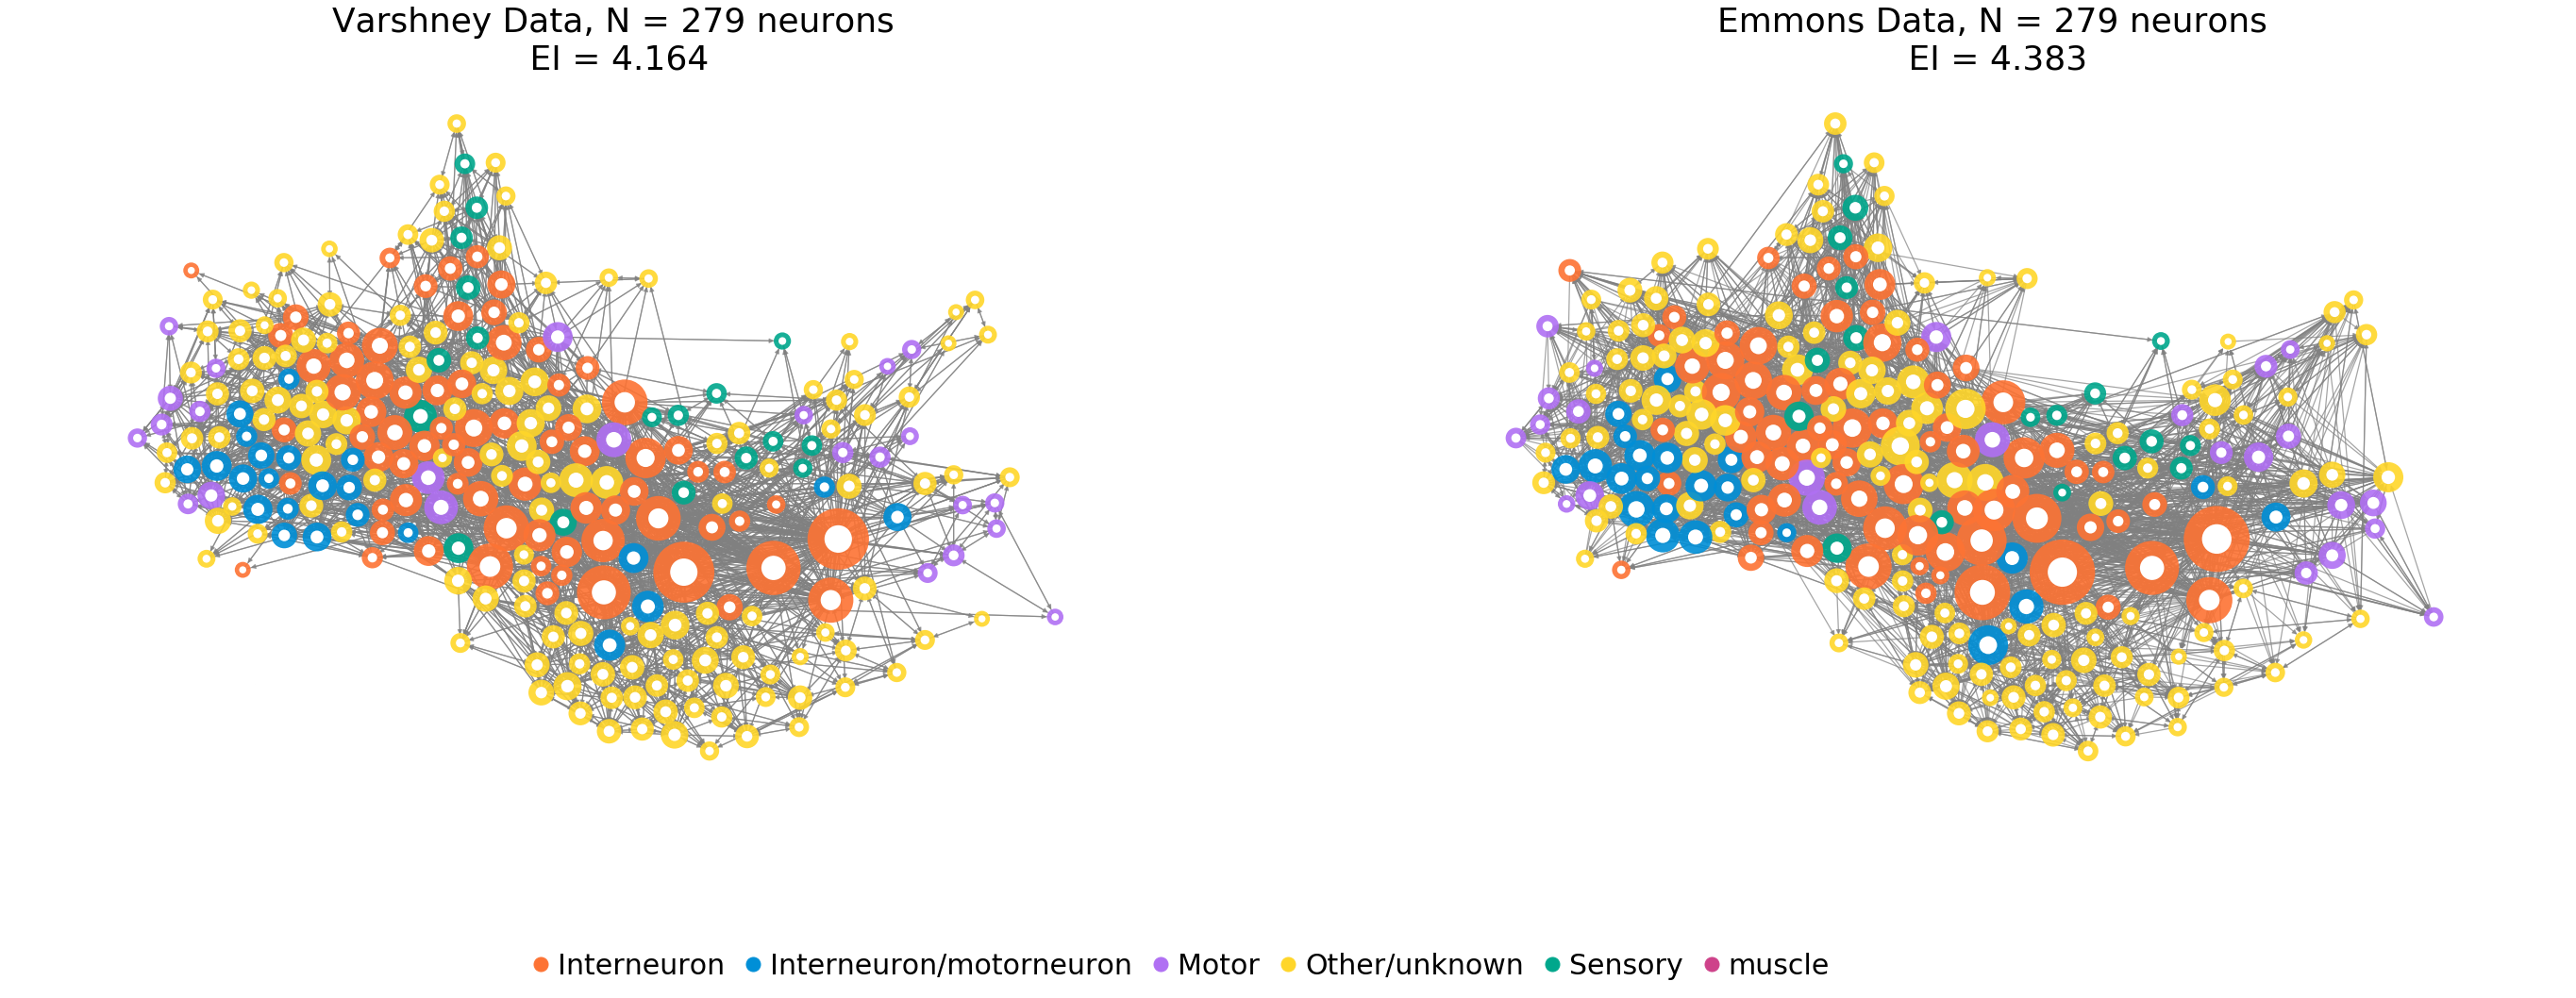

In [19]:
w = 16*2
h = 11
mult = 1.5
paddin = 100

fig, (ax0,ax1) = plt.subplots(1,2,figsize=(w*mult,h*mult))

# Varshney
nx.draw_networkx_nodes(Gv2, pos=pos_v, node_color=nc_v, node_size=ns_v,   linewidths=0, alpha=0.9, ax=ax0)
nx.draw_networkx_nodes(Gv2, pos=pos_v, node_color='w',  node_size=ns_v/5, linewidths=0, alpha=1.0, ax=ax0)
nx.draw_networkx_edges(Gv2, pos=pos_v, edge_color="grey", width=1.25, alpha=0.7, ax=ax0)
ax0.set_title("Varshney Data, N = %i neurons\n EI = %.3f"%(Gv2.number_of_nodes(), get_ei(Gv2)), size=36)
x, y = zip(*pos_v)
ax0.set_xlim(min(x)-100, max(x)+100)
ax0.set_ylim(min(y)-100, max(y)+100)
ax0.set_axis_off()

# Emmons
nx.draw_networkx_nodes(Ge2, pos=pos_e, node_color=nc_e, node_size=ns_e,   linewidths=0, alpha=0.9, ax=ax1)
nx.draw_networkx_nodes(Ge2, pos=pos_e, node_color='w',  node_size=ns_e/5, linewidths=0, alpha=1.0, ax=ax1)
nx.draw_networkx_edges(Ge2, pos=pos_e, edge_color="grey", width=1.25, alpha=0.7, ax=ax1)
ax1.set_title("Emmons Data, N = %i neurons\n EI = %.3f"%(Ge2.number_of_nodes(), get_ei(Ge2)), size=36)
x, y = zip(*list(pos_e.values()))
ax1.set_xlim(min(x)-100, max(x)+100)
ax1.set_ylim(min(y)-100, max(y)+100)
ax1.set_axis_off()

for i in color_mapping.keys():
    ax0.plot([-10000], [10000], color=color_mapping[i], marker='o', markersize=15, linestyle='', label=i)

# ax1.text(700, 700, "Additional nodes in Emmons", fontsize=20)
# ax1.plot([650], [710], marker='o', linestyle='', color='limegreen', markersize=18)
# ax1.plot([650], [710], marker='o', linestyle='', color='w', markersize=3)
ax0.legend(fontsize=20*mult, columnspacing=0.0, handletextpad=-0.4, loc=3, framealpha=0.0, ncol=6, 
           bbox_to_anchor=(0.26*mult, -0.1))

# plt.savefig("../figs/pngs/Emmons_Varshney_compare2.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Emmons_Varshney_compare2.pdf", bbox_inches='tight')
plt.show()

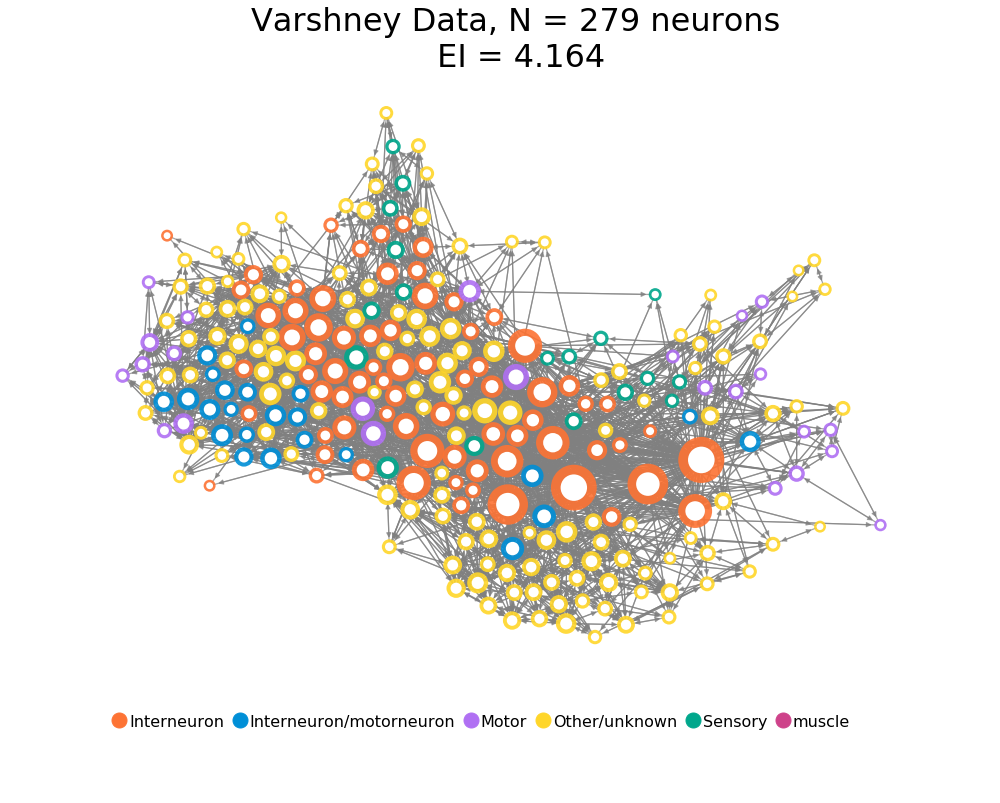

In [50]:
h = 13
w = 17
mult = 1.0
paddin = 100
plt.figure(figsize=(w*mult,h*mult))
nx.draw_networkx_nodes(Gv2, pos=pos_v, node_color=nc_v, node_size=ns_v*.5,   linewidths=0, alpha=0.9)
nx.draw_networkx_nodes(Gv2, pos=pos_v, node_color='w',  node_size=ns_v/6, linewidths=0, alpha=1.0)
nx.draw_networkx_edges(Gv2, pos=pos_v, edge_color="grey", width=1.25, alpha=0.7)
plt.axis('off')

for i in color_mapping.keys():
    plt.plot([-10000], [10000], color=color_mapping[i], marker='o', markersize=15, linestyle='', label=i)

plt.legend(fontsize=16*mult, columnspacing=0.0, handletextpad=-0.4, loc=3, framealpha=0.0, ncol=6, 
           bbox_to_anchor=(0.05*mult, 0.05))

plt.title("Varshney Data, N = %i neurons\n EI = %.3f"%(Gv2.number_of_nodes(), get_ei(Gv2)), size=32)
x, y = zip(*pos_v)
plt.xlim(min(x)-100, max(x)+100)
plt.ylim(min(y)-100, max(y)+100)
# plt.savefig("../figs/pngs/Varshney_celegans.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Varshney_celegans.pdf", bbox_inches='tight')
plt.show()

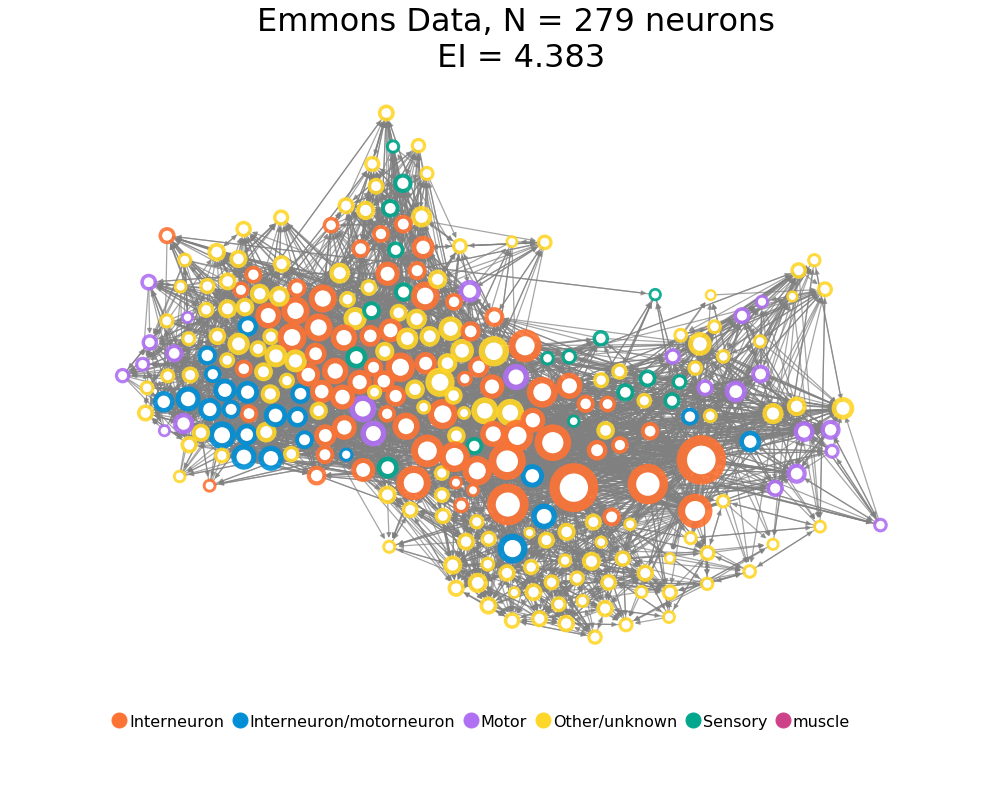

In [51]:
h = 13
w = 17
mult = 1.0
paddin = 100
plt.figure(figsize=(w*mult,h*mult))
nx.draw_networkx_nodes(Ge2, pos=pos_e, node_color=nc_e, node_size=ns_e*.5,   linewidths=0, alpha=0.9)
nx.draw_networkx_nodes(Ge2, pos=pos_e, node_color='w',  node_size=ns_e/6, linewidths=0, alpha=1.0)
nx.draw_networkx_edges(Ge2, pos=pos_e, edge_color="grey", width=1.25, alpha=0.7)

plt.axis('off')

for i in color_mapping.keys():
    plt.plot([-10000], [10000], color=color_mapping[i], marker='o', markersize=15, linestyle='', label=i)

plt.legend(fontsize=16*mult, columnspacing=0.0, handletextpad=-0.4, loc=3, framealpha=0.0, ncol=6, 
           bbox_to_anchor=(0.05*mult, 0.05))

plt.title("Emmons Data, N = %i neurons\n EI = %.3f"%(Ge2.number_of_nodes(), get_ei(Ge2)), size=32)
x, y = zip(*list(pos_e.values()))
plt.xlim(min(x)-100, max(x)+100)
plt.ylim(min(y)-100, max(y)+100)
# plt.savefig("../figs/pngs/Emmons_celegans.png", dpi=425, bbox_inches='tight')
# plt.savefig("../figs/pdfs/Emmons_celegans.pdf", bbox_inches='tight')
plt.show()

# Causal Emergence

In [25]:
print("We know the following about nodes in Varshney:", sorted(Gv2.nodes(data=True)[0]))
print("We know the following about nodes in Emmons:  ", sorted(Ge2.nodes(data=True)[0]))

We know the following about nodes in Varshney: ['color', 'name', 'pos', 'size']
We know the following about nodes in Emmons:   ['color', 'name', 'pos', 'size']


In [26]:
# print("We know the following about nodes in Varshney:", sorted(G_varshney.nodes(data=True)[0]))
# print("We know the following about nodes in Emmons:  ", sorted(G_emmons.nodes(data=True)[0]))

In [23]:
d_away = 2
# d_away = 1
nodepairs_d2_varshney = get_paths(Gv2, d=d_away)
nodepairs_d2_emmons   = get_paths(Ge2, d=d_away)

print("In Varshney, the density is:", np.round(nx.density(Gv2), 5))
print("In Emmons,   the density is:", np.round(nx.density(Ge2),   5))
print()
print("In Varshney, there are", len(nodepairs_d2_varshney), "pairs of nodes at d =",d_away,"from one another.")
print("In Emmons,   there are", len(nodepairs_d2_emmons),   "pairs of nodes at d =",d_away,"from one another.")
print()
# Let's try to macronode nodes in these networks 100 times.
n_steps = 50
n_edges_sampled = 500
G_macro_Varshney = Gv2.copy()
G_macro_Emmons   = Ge2.copy()
print("Varshney starts with N =", G_macro_Varshney.number_of_nodes(), 
      "nodes and EI =", np.round(get_ei(G_macro_Varshney),5))
print("Emmons   starts with N =", G_macro_Emmons.number_of_nodes(),
      "nodes and EI =", np.round(get_ei(G_macro_Emmons),  5))

In Varshney, the density is: 0.05901
In Emmons,   the density is: 0.06321

In Varshney, there are 41622 pairs of nodes at d = 2 from one another.
In Emmons,   there are 39400 pairs of nodes at d = 2 from one another.

Varshney starts with N = 279 nodes and EI = 4.1641
Emmons   starts with N = 279 nodes and EI = 4.3827


In [24]:
# # d_away = 2
# d_away = 1
# nodepairs_d2_varshney = get_paths(G_varshney, d=d_away)
# nodepairs_d2_emmons   = get_paths(G_emmons,   d=d_away)

# print("In Varshney, the density is:", np.round(nx.density(G_varshney), 5))
# print("In Emmons,   the density is:", np.round(nx.density(G_emmons),   5))
# print()
# print("In Varshney, there are", len(nodepairs_d2_varshney), "pairs of nodes at d =",d_away,"from one another.")
# print("In Emmons,   there are", len(nodepairs_d2_emmons),   "pairs of nodes at d =",d_away,"from one another.")
# print()
# # Let's try to macronode nodes in these networks 100 times.
# n_steps = 50
# n_edges_sampled = 500
# G_macro_Varshney = G_varshney.copy()
# G_macro_Emmons   = G_emmons.copy()
# print("Varshney starts with N =", G_macro_Varshney.number_of_nodes(), 
#       "nodes and EI =", np.round(get_ei(G_varshney),5))
# print("Emmons   starts with N =", G_emmons.number_of_nodes(),
#       "nodes and EI =", np.round(get_ei(G_emmons),  5))

In [27]:
macronodes_Varshney = {}
macronodes_Emmons   = {}

print("Starting to span the possible groupings at:", datetime.datetime.now())
for i in range(n_steps):
    index_to_check_V = np.random.choice(range(len(nodepairs_d2_varshney)), size=n_edges_sampled)
    edges_to_check_V = np.array(nodepairs_d2_varshney)[index_to_check_V]
    edges_to_check_V = [tuple(edges_to_check_V[i]) for i in range(len(edges_to_check_V))]
    
    index_to_check_E = np.random.choice(range(len(nodepairs_d2_emmons)),   size=n_edges_sampled)
    edges_to_check_E = np.array(  nodepairs_d2_emmons)[index_to_check_E]
    edges_to_check_E = [tuple(edges_to_check_E[i]) for i in range(len(edges_to_check_E))]
    
    ei_diff_dict_V, success_edges_V = get_ei_diff(G_macro_Varshney, edges_to_check_V)
    ei_diff_dict_E, success_edges_E = get_ei_diff(G_macro_Emmons,   edges_to_check_E)
    
    if success_edges_V: 
        macro_edge_V = sorted(success_edges_V.items(), key=operator.itemgetter(1))[0][0]
        for eij in success_edges_V:
            if eij not in list(macronodes_Varshney.keys()):
                macronodes_Varshney[eij] = ei_diff_dict_V[eij]
                
    if success_edges_E: 
        macro_edge_E = sorted(success_edges_E.items(), key=operator.itemgetter(1))[0][0]
        for eij in success_edges_E:
            if eij not in list(macronodes_Emmons.keys()):
                macronodes_Emmons[eij] = ei_diff_dict_E[eij]
                
    print("Finished with iteration %02i at:"%i, datetime.datetime.now())

Starting to span the possible groupings at: 2018-09-05 11:20:35.913507
Finished with iteration 00 at: 2018-09-05 11:22:12.854027
Finished with iteration 01 at: 2018-09-05 11:23:51.505337
Finished with iteration 02 at: 2018-09-05 11:25:20.928972
Finished with iteration 03 at: 2018-09-05 11:26:48.688600
Finished with iteration 04 at: 2018-09-05 11:28:16.496762
Finished with iteration 05 at: 2018-09-05 11:29:45.353818
Finished with iteration 06 at: 2018-09-05 11:31:12.900356
Finished with iteration 07 at: 2018-09-05 11:32:44.678806
Finished with iteration 08 at: 2018-09-05 11:34:14.496413
Finished with iteration 09 at: 2018-09-05 11:35:44.513136
Finished with iteration 10 at: 2018-09-05 11:37:18.132983
Finished with iteration 11 at: 2018-09-05 11:38:55.427360
Finished with iteration 12 at: 2018-09-05 11:40:34.780755
Finished with iteration 13 at: 2018-09-05 11:42:12.647850
Finished with iteration 14 at: 2018-09-05 11:43:47.175511
Finished with iteration 15 at: 2018-09-05 11:45:24.980231
F

In [52]:
print("This process found", len(macronodes_Varshney.keys()), "possible pairs of nodes to group in Varshney.")
print("This process found", len(macronodes_Emmons.keys()),   "possible pairs of nodes to group in Emmons.")
print()
print("There is a potential gain of EI of", -sum(list(macronodes_Varshney.values())), "in Varshney.")
print("There is a potential gain of EI of", -sum(list(macronodes_Emmons.values())),   "in Emmons.")

This process found 106 possible pairs of nodes to group in Varshney.
This process found 5 possible pairs of nodes to group in Emmons.

There is a potential gain of EI of 0.07175062919656483 in Varshney.
There is a potential gain of EI of 0.001101756133586207 in Emmons.


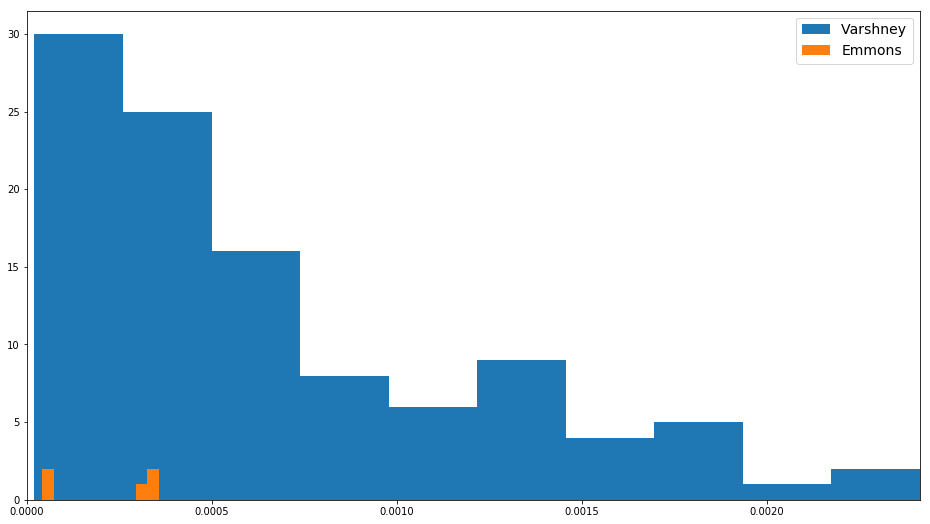

In [31]:
plt.figure(figsize=(16,9))
plt.hist(-1*np.array(list(macronodes_Varshney.values())), label='Varshney')
plt.hist(-1*np.array(list(macronodes_Emmons.values())),   label='Emmons')

plt.legend(fontsize=14)
plt.xlim(0, max(-1*np.array(list(macronodes_Varshney.values()))))
plt.show()

In [ ]:
# do configuration model on c elegans and see if there is causal emergence 